In [ ]:
import ast
import numpy as np 
import os 
from PIL import Image, ImageOps

import torch 
from torch.utils.data import Dataset
from torchvision import transforms

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
import cv2
import csv

In [ ]:
# Linking Google drive to use preprocessed data 
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
#/content/drive/My Drive//

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/Mental_health_chatbot/data 

dataset_journal_entries.csv	   dataset_none_class_entries.csv
dataset_merged_mh_journalling.csv  emotion_image_data
dataset_mh_journal.csv		   trigger_warnings_dataset.csv


## Image preprocessing

Image processing could be simple tasks like image resizing. Note that, to feed a dataset of images to a CNN, they must all be the same size. Other processing tasks can take place like geometric and color transformation or converting color to grayscale and many more. We use preprocessed images to reduce space or computational complexity for our models.

Image preprocessing techniques:
* Resize/rescale
* Normalize
* Convert RGB to grayscale images (color images are represented in three channels, so converting to grayscale reduces the number of pixels that need to be processed)

In [ ]:
data_df = pd.read_csv("/content/drive/MyDrive/Mental_health_chatbot/data/emotion_image_data/emotic_pre/train.csv").drop(['Index'],axis=1)

In [ ]:
data_df.head(-20)

,Folder,Filename,Image Size,BBox,Categorical_Labels,Continuous_Labels,Gender,Age
0,mscoco/images,COCO_val2014_000000562243.jpg,"[640, 640]","[86, 58, 564, 628]","['Disconnection', 'Doubt/Confusion']","[5, 3, 9]",Male,Adult
1,mscoco/images,COCO_train2014_000000288841.jpg,"[640, 480]","[485, 149, 605, 473]",['Anticipation'],"[6, 4, 7]",Male,Adult
2,mscoco/images,COCO_val2014_000000558171.jpg,"[640, 480]","[305, 92, 461, 465]","['Engagement', 'Excitement', 'Happiness']","[7, 8, 8]",Male,Teenager
3,mscoco/images,COCO_train2014_000000369575.jpg,"[480, 640]","[221, 63, 448, 372]","['Aversion', 'Pleasure']","[8, 9, 8]",Male,Kid
4,mscoco/images,COCO_train2014_000000213009.jpg,"[500, 333]","[44, 143, 150, 288]","['Confidence', 'Excitement']","[7, 9, 10]",Male,Adult
...,...,...,...,...,...,...,...,...
23241,mscoco/images,COCO_train2014_000000101249.jpg,"[640, 334]","[387, 135, 555, 270]","['Engagement', 'Excitement']","[5, 7, 7]",Male,Adult
23242,mscoco/images,COCO_train2014_000000541690.jpg,"[640, 480]","[252, 107, 413, 473]","['Confidence', 'Engagement']","[6, 4, 7]",Male,Teenager
23243,framesdb/images,frame_fwxrk1awxnxn3osc.jpg,"[3892, 2595]","[202, 30, 1274, 2594]","['Disquietment', 'Embarrassment']","[3, 6, 3]",Male,Adult
23244,framesdb/images,frame_fwxrk1awxnxn3osc.jpg,"[3892, 2595]","[2039, 416, 3312, 2569]","['Anger', 'Excitement']","[5, 2, 9]",Male,Adult


In [ ]:
data_df.columns

Index(['Folder', 'Filename', 'Image Size', 'BBox', 'Categorical_Labels',
       'Continuous_Labels', 'Gender', 'Age'],
      dtype='object')

In [ ]:
len(data_df)

23266

In [ ]:
data_df['Folder'].unique()

array(['mscoco/images', 'emodb_small/images', 'framesdb/images',
       'ade20k/images'], dtype=object)

## Define customized DatasetLoader

In [ ]:
class Emotic_CSVDataset(Dataset):
  ''' Custom Emotic dataset class. Use csv files and generated data at runtime. '''
  def __init__(self, data_df, cat2ind, transform, context_norm, body_norm, data_src = './'):
    super(Emotic_CSVDataset,self).__init__()
    self.data_df = data_df
    self.data_src = data_src 
    self.transform = transform 
    self.cat2ind = cat2ind
    self.context_norm = transforms.Normalize(context_norm[0], context_norm[1])  # Normalizing the context image with context mean and context std
    self.body_norm = transforms.Normalize(body_norm[0], body_norm[1])           # Normalizing the body image with body mean and body std

  def __len__(self):
    return len(self.data_df)
  
  def getitem(self, index):
    row = self.data_df.loc[index]
    image_context = Image.open(os.path.join(self.data_src, row['Folder'], row['Filename']))
    bbox = ast.literal_eval(row['BBox'])
    image_body = image_context.crop((bbox[0], bbox[1], bbox[2], bbox[3]))
    image_context = image_context.resize((224, 224))
    image_body = image_body.resize((128, 128))
    cat_labels = ast.literal_eval(row['Categorical_Labels'])
    cont_labels = ast.literal_eval(row['Continuous_Labels'])
    one_hot_cat_labels = self.cat_to_one_hot(cat_labels)
    return self.context_norm(self.transform(image_context)), self.body_norm(self.transform(image_body)), torch.tensor(one_hot_cat_labels, dtype=torch.float32), torch.tensor(cont_labels, dtype=torch.float32)/10.0
  
  def cat_to_one_hot(self, cat):
    one_hot_cat = np.zeros(26)
    for em in cat:
      one_hot_cat[self.cat2ind[em]] = 1
    return one_hot_cat

## Convert emotional categories to integer

In [ ]:
# one-hot encoding categories
cat = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion', 'Confidence', 'Disapproval', 'Disconnection', \
            'Disquietment', 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue', 'Fear','Happiness', \
            'Pain', 'Peace', 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy', 'Yearning']

In [ ]:
# cat2ind: Dictionary converting categorical emotion to integer index
# ind2cat: Dictionary converting integer index to categorical emotion

cat2ind = {}
ind2cat = {}
for idx, emotion in enumerate(cat):
  cat2ind[emotion] = idx
  ind2cat[idx] = emotion

In [ ]:
ind2cat

{0: 'Affection',
 1: 'Anger',
 2: 'Annoyance',
 3: 'Anticipation',
 4: 'Aversion',
 5: 'Confidence',
 6: 'Disapproval',
 7: 'Disconnection',
 8: 'Disquietment',
 9: 'Doubt/Confusion',
 10: 'Embarrassment',
 11: 'Engagement',
 12: 'Esteem',
 13: 'Excitement',
 14: 'Fatigue',
 15: 'Fear',
 16: 'Happiness',
 17: 'Pain',
 18: 'Peace',
 19: 'Pleasure',
 20: 'Sadness',
 21: 'Sensitivity',
 22: 'Suffering',
 23: 'Surprise',
 24: 'Sympathy',
 25: 'Yearning'}

In [ ]:
# ind2vad: Dictionary converting integer index to continuous emotion dimension
vad = ['Valence', 'Arousal', 'Dominance']
ind2vad = {}
for idx, continuous in enumerate(vad):
  ind2vad[idx] = continuous

## Transformation

In [ ]:
# context_norm: List containing mean and std values for context images
# body_norm: List containing mean and std values for body images.
context_mean = [0.4690646, 0.4407227, 0.40508908]
context_std = [0.2514227, 0.24312855, 0.24266963]
body_mean = [0.43832874, 0.3964344, 0.3706214]
body_std = [0.24784276, 0.23621225, 0.2323653]
context_norm = [context_mean, context_std]
body_norm = [body_mean, body_std]

In [ ]:
#train_transform = transforms.Compose([
                                      #transforms.RandomHorizontalFlip(), 
                                      #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4), 
                                      #transforms.ToTensor()])

In [ ]:
transform_ = transforms.Compose([transforms.ToTensor()])

## Load dataset

Now, we have all 5 required arguments. We can start loading our dataset for some visualization

In [ ]:
data_src = "/content/drive/MyDrive/Mental_health_chatbot/data/emotion_image_data/emotic"

### Understand functions in the `Emotic_CSVDataset`

In [ ]:
def cat_to_one_hot(cat,cat2ind):
    one_hot_cat = np.zeros(26)
    for em in cat:
      one_hot_cat[cat2ind[em]] = 1
    return one_hot_cat

In [ ]:
def getitem(data_df, index, data_src):
    row = data_df.loc[index]
    image_context = Image.open(os.path.join(data_src, row['Folder'], row['Filename']))
    bbox = ast.literal_eval(row['BBox'])
    image_body = image_context.crop((bbox[0], bbox[1], bbox[2], bbox[3])) # only select the content within the bbox
    image_context_ = image_context.resize((224, 224)) # resize images into (224x224)
    image_body = image_body.resize((128, 128))
    return image_context, bbox, image_body, image_context_

In [ ]:
image_context, bbox, image_body, image_context_ = getitem(data_df, 11, data_src)

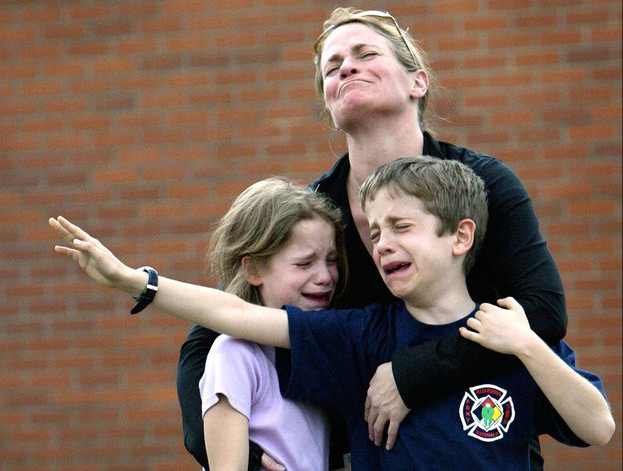

In [ ]:
image_context

In [ ]:
bbox

[177, 11, 471, 471]

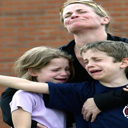

In [ ]:
image_body

### Display bounding boxes

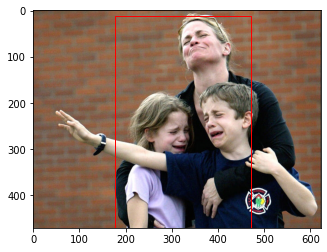

In [ ]:
# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(image_context)

# Create a Rectangle patch
# ((x_1,y_1), width, height ) 
# where width = x_2 - x_1
# height = y_2 - y_1
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

### Initialize `Emotic_CSVDataset`

In [ ]:
emotic_data = Emotic_CSVDataset(data_df, cat2ind, transform_, context_norm, body_norm,data_src)

In [ ]:
context_norm, body_norm, categorical, continuous = emotic_data.getitem(11)

In [ ]:
# torch tensor of shape [channels, height, width]
body_norm.shape 

torch.Size([3, 128, 128])

In [ ]:
categorical

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 1., 0., 1., 0.])

In [ ]:
continuous

tensor([0.2000, 0.3000, 0.4000])

### Visualize normalized image

In [ ]:
transform = transforms.ToPILImage()
img = transform(body_norm)

In [ ]:
body_norm.shape

torch.Size([3, 128, 128])

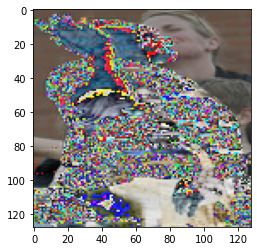

In [ ]:
fig, ax = plt.subplots()

# Display the image
ax.imshow(img)

plt.show()

In [ ]:
# check normalized image shape
# convert from PIL Image to np array
image = np.array(img)
# check shape of image
image.shape

(128, 128, 3)

They decided to keep 3 channels. However, it might not be necessary. We want to keep everything as light as possible during our training. So, our goal is to convert it into grayscale images.

In [ ]:
gray_image = ImageOps.grayscale(img)

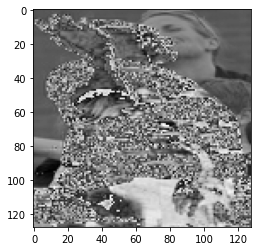

In [ ]:
fig, ax = plt.subplots()

# Display the image
ax.imshow(gray_image,cmap='gray')

plt.show()

In [ ]:
# convert from PIL Image to np array
image = np.array(gray_image)

In [ ]:
# check shape of image
image.shape

(128, 128)

In [ ]:
name = 'train0'

In [ ]:
gray_image.save(name + '.png')

### Train set processing

In [ ]:
import pathlib
from pathlib import Path

In [ ]:
!mkdir /content/drive/MyDrive/Mental_health_chatbot/data/emotion_image_data/emotic_preprocessed

In [ ]:
# Path of current working directory
path = Path('/content/drive/MyDrive/Mental_health_chatbot/data/emotion_image_data/emotic_preprocessed/train')
path

PosixPath('/content/drive/MyDrive/Mental_health_chatbot/data/emotion_image_data/emotic_preprocessed/train')

We'll structure our preprocessed folder like this
```
├── ade20k
│   └── images
├── emodb_small
│   └── images
├── framesdb
│   └── images
└── mscoco
    └── images
```

In [ ]:
# folder structure
folders = {'ade20k':['images'],'emodb_small':['images'],'framesdb':['images'],'mscoco':['images']}
folders

{'ade20k': ['images'],
 'emodb_small': ['images'],
 'framesdb': ['images'],
 'mscoco': ['images']}

In [ ]:
if not path.exists():
  path.mkdir(exist_ok=True)
  for o in folders:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    for item in folders[o]:
      dest_image = (path/o/item)
      dest_image.mkdir(exist_ok=True)


In [ ]:
output_path = "/content/drive/MyDrive/Mental_health_chatbot/data/emotion_image_data/emotic_preprocessed/train"

In [ ]:
os.path.join(emotic_data.data_df['Folder'][0],emotic_data.data_df['Filename'][0])

'mscoco/images/COCO_val2014_000000562243.jpg'

In [ ]:
dataset_type = 'train'

In [103]:
csv_path = os.path.join(output_path, "%s.csv" %(dataset_type))
csv_path

'/content/drive/MyDrive/Mental_health_chatbot/data/emotion_image_data/emotic_preprocessed/train/train.csv'

In [ ]:
with open(csv_path, 'w') as csvfile:
  filewriter = csv.writer(csvfile, delimiter=',', dialect='excel')
  row = ['Index', 'Folder', 'Filename', 'Image Size', 'Categorical_Labels', 'Gender', 'Age']
  filewriter.writerow(row)

  for i in range(len(data_df)):
    context_norm, body_norm, categorical, continuous = emotic_data.getitem(i)
    transform = transforms.ToPILImage()
    img = transform(body_norm)
    gray_image = ImageOps.grayscale(img)
    im_size = np.array(gray_image).shape
    # save gray scaled image into desired dir
    gray_image.save(os.path.join(output_path,os.path.join(emotic_data.data_df['Folder'][i],emotic_data.data_df['Filename'][i])))
    # save csv file
    row = [i, emotic_data.data_df['Folder'][i], emotic_data.data_df['Filename'][i], im_size, 
            emotic_data.data_df['Categorical_Labels'][i], 
            emotic_data.data_df['Gender'][i],
            emotic_data.data_df['Age'][i]]
    filewriter.writerow(row)


In [105]:
len(data_df)

23266

In [108]:
with open(csv_path, 'w') as csvfile:
  filewriter = csv.writer(csvfile, delimiter=',', dialect='excel')
  row = ['Index', 'Folder', 'Filename', 'Image Size', 'Categorical_Labels', 'Gender', 'Age']
  for i in range(22096,23266):
      context_norm, body_norm, categorical, continuous = emotic_data.getitem(i)
      transform = transforms.ToPILImage()
      img = transform(body_norm)
      gray_image = ImageOps.grayscale(img)
      im_size = np.array(gray_image).shape
      # save gray scaled image into desired dir
      gray_image.save(os.path.join(output_path,os.path.join(emotic_data.data_df['Folder'][i],emotic_data.data_df['Filename'][i])))
      # save csv file
      row = [i, emotic_data.data_df['Folder'][i], emotic_data.data_df['Filename'][i], im_size, 
              emotic_data.data_df['Categorical_Labels'][i], 
              emotic_data.data_df['Gender'][i],
              emotic_data.data_df['Age'][i]]
      filewriter.writerow(row)

In [ ]:
#!rm -r /content/drive/MyDrive/Mental_health_chatbot/data/emotion_image_data/emotic_preprocessed/train

In [111]:
check_df = pd.read_csv("/content/drive/MyDrive/Mental_health_chatbot/data/emotion_image_data/emotic_preprocessed/train/train.csv")

In [112]:
check_df

,Index,Folder,Filename,Image Size,Categorical_Labels,Gender,Age
0,0,mscoco/images,COCO_val2014_000000562243.jpg,"(128, 128)","['Disconnection', 'Doubt/Confusion']",Male,Adult
1,1,mscoco/images,COCO_train2014_000000288841.jpg,"(128, 128)",['Anticipation'],Male,Adult
2,2,mscoco/images,COCO_val2014_000000558171.jpg,"(128, 128)","['Engagement', 'Excitement', 'Happiness']",Male,Teenager
3,3,mscoco/images,COCO_train2014_000000369575.jpg,"(128, 128)","['Aversion', 'Pleasure']",Male,Kid
4,4,mscoco/images,COCO_train2014_000000213009.jpg,"(128, 128)","['Confidence', 'Excitement']",Male,Adult
...,...,...,...,...,...,...,...
23261,23261,mscoco/images,COCO_train2014_000000175368.jpg,"(128, 128)",['Confidence'],Male,Adult
23262,23262,mscoco/images,COCO_val2014_000000514083.jpg,"(128, 128)","['Anticipation', 'Engagement', 'Excitement']",Male,Adult
23263,23263,framesdb/images,frame_k7fb824vh221kl3j.jpg,"(128, 128)",['Engagement'],Male,Adult
23264,23264,mscoco/images,COCO_val2014_000000244665.jpg,"(128, 128)",['Sympathy'],Female,Adult
